In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla
import scipy.sparse.linalg as spla
import scipy.io as sio
import meshio
import dolfin as dl
from time import time

import localpsfcpp as lpsf

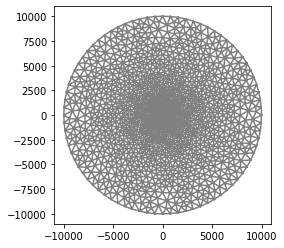

In [2]:
vertices = np.loadtxt('mesh_vertices.txt')
cells = np.loadtxt('mesh_cells.txt', dtype=int)
dof_coords = np.loadtxt('dof_coords.txt')
vertex_in_dof = np.loadtxt('vertex_in_dof.txt', dtype=int)
dof_in_vertex = np.loadtxt('dof_in_vertex.txt', dtype=int)

mesh_meshio = meshio.Mesh(vertices, [("triangle", cells)])
mesh_meshio.write("mesh.xml")
mesh = dl.Mesh("mesh.xml")
dl.plot(mesh)

In [3]:
Hdgn = np.loadtxt('Hdgn_array.txt')
sqrtR = sio.loadmat('sqrtR_matrix.mat')['sqrtR']
M = sio.loadmat('mass_matrix.mat')['M']
# mass_lumps = np.loadtxt('mass_matrix_diagonal.txt')
mass_lumps = M * np.ones(M.shape[1])

Ker = Hdgn / (mass_lumps.reshape(1,-1) * mass_lumps.reshape(-1,1))

apply_Hdgn = lambda x: np.dot(Hdgn, x)
apply_HdgnT = lambda x: np.dot(Hdgn, x)
apply_M = lambda x: M * x
solve_M = spla.factorized(M)
apply_ML = lambda x: x * mass_lumps
solve_ML = lambda x: x / mass_lumps

In [4]:
R = sqrtR.toarray().T @ np.linalg.solve(M.toarray(), sqrtR.toarray())

In [5]:
V = dl.FunctionSpace(mesh, 'CG', 1)

err_dof_coords = np.linalg.norm(dof_coords - V.tabulate_dof_coordinates()) / np.linalg.norm(V.tabulate_dof_coordinates())
print('err_dof_coords=', err_dof_coords)

err_dof_coords= 0.0


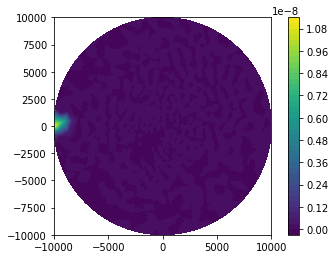

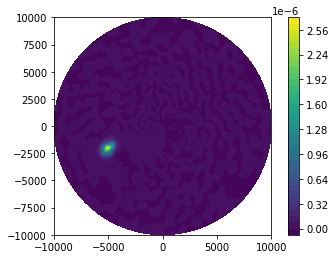

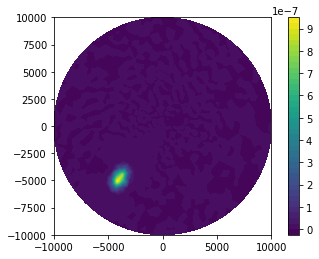

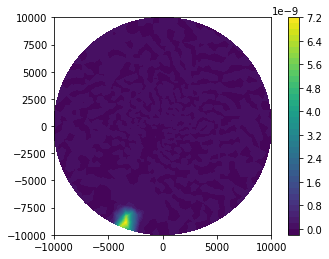

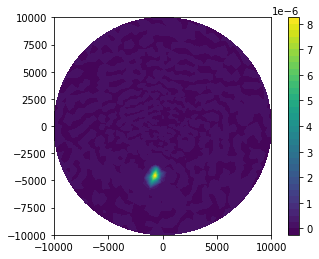

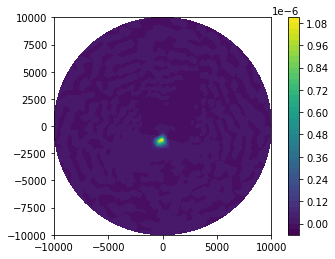

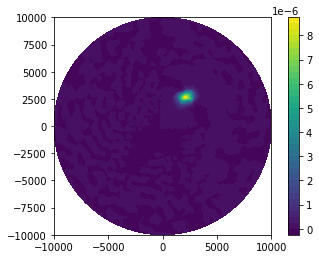

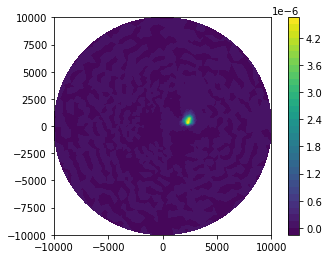

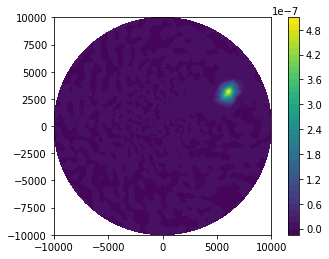

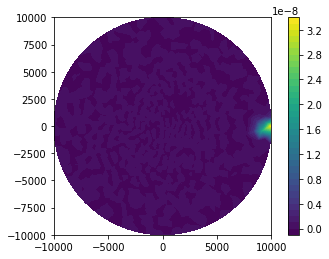

In [6]:
kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    psi_k = dl.Function(V)
    psi_k.vector()[:] = solve_ML(apply_Hdgn(solve_ML(ek)))

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)

In [7]:
err_reorder = np.linalg.norm(dof_coords - vertices[dof_in_vertex,:]) / np.linalg.norm(dof_coords)
print('err_reorder=', err_reorder)

vertices_dof_order = np.array(vertices[dof_in_vertex,:].T, order='C')
# cells_dof_order    = np.array(cells[dof_in_vertex,:].T,    order='C') # BAD
cells_dof_order    = np.array(vertex_in_dof[cells].T,    order='C') # GOOD

err_reorder= 0.0


In [8]:
from matplotlib.patches import Ellipse

def plot_ellipse(mu, Sigma, n_std_tau, ax=None, **kwargs):
    # Usage:
    #   https://github.com/NickAlger/nalger_helper_functions/tree/master/jupyter_notebooks/plot_ellipse.ipynb
    if ax is None:
        ax = plt.gca()

    ee, V = np.linalg.eigh(Sigma)
    e_big = ee[1]
    e_small = ee[0]
    v_big = V[:, 1]
    theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi

    long_length = n_std_tau * 2. * np.sqrt(e_big)
    short_length = n_std_tau * 2. * np.sqrt(e_small)

    if not ('facecolor' in kwargs):
        kwargs['facecolor'] = 'none'

    if not ('edgecolor' in kwargs):
        kwargs['edgecolor'] = 'k'

    ellipse = Ellipse(mu, width=long_length, height=short_length, angle=theta, **kwargs)
    ax.add_artist(ellipse)

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1


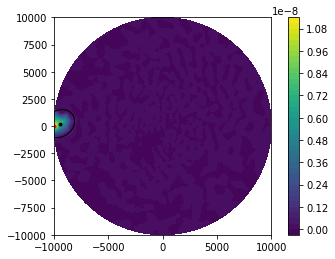

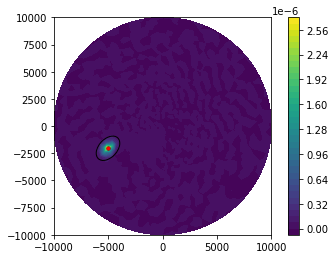

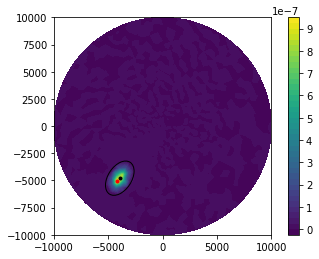

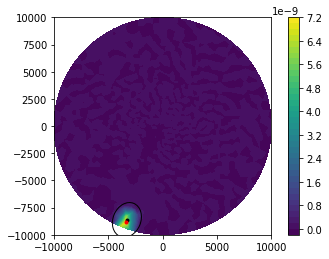

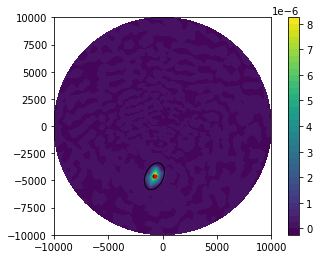

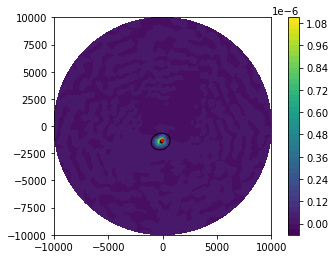

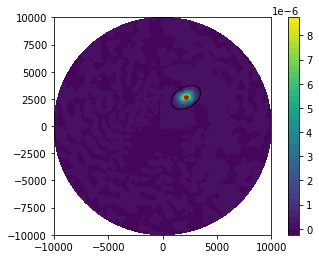

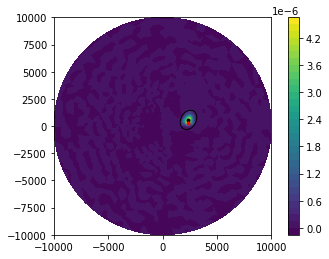

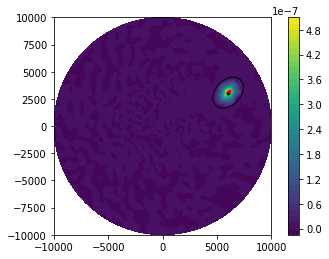

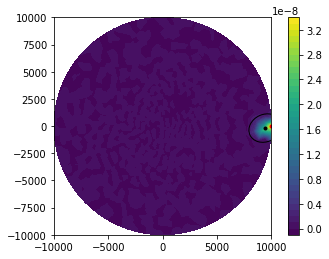

In [9]:
vol, mu, Sigma = lpsf.compute_impulse_response_moments(apply_HdgnT, solve_ML, vertices_dof_order)
# vol, mu, Sigma = lpsf.compute_impulse_response_moments(apply_HdgnT, solve_M, vertices_dof_order)

tau = 3.0

kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    psi_k = dl.Function(V)
    psi_k.vector()[:] = solve_ML(apply_Hdgn(solve_ML(ek)))

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)
    plt.plot(mu[k][0], mu[k][1], '.k')
    plot_ellipse(mu[k], Sigma[k], tau, edgecolor='k')
    plt.plot(vertices_dof_order[0,k], vertices_dof_order[1,k], '.r')

In [10]:
num_neighbors = 10
min_vol_rtol = 1e-5
num_initial_batches = 25

lpsf_kernel = lpsf.create_LPSFKernel(apply_Hdgn, apply_HdgnT, apply_ML, apply_ML, solve_ML, solve_ML, 
                                    vertices_dof_order, vertices_dof_order, cells_dof_order, 
                                    tau, num_neighbors, min_vol_rtol, num_initial_batches)

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch
computing impulse response batch


/tmp/ipykernel_603776/3995634747.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


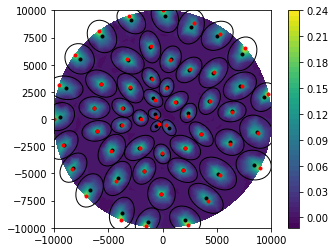

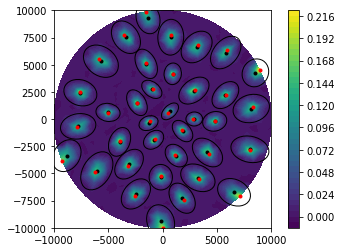

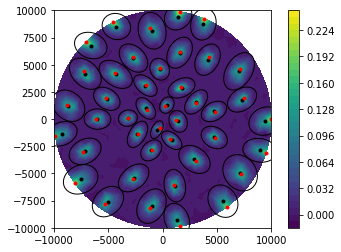

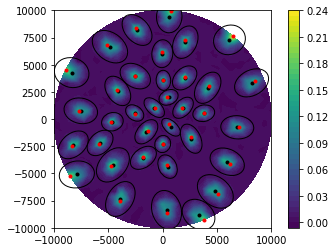

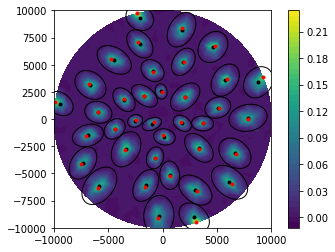

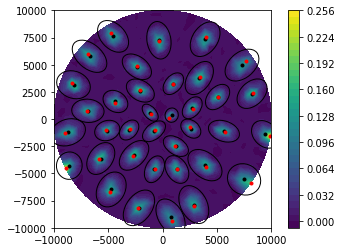

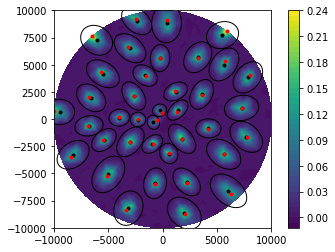

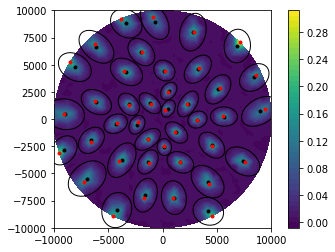

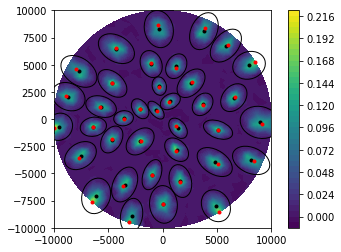

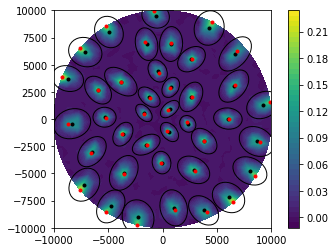

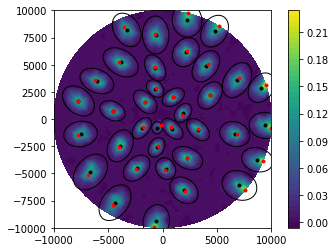

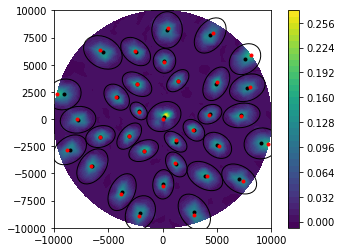

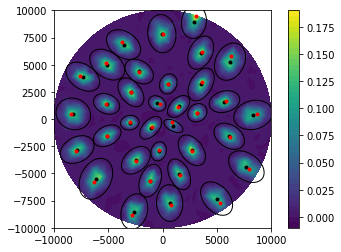

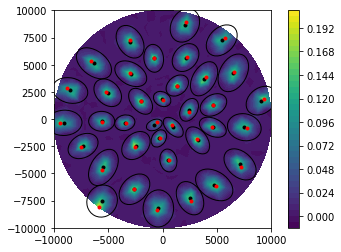

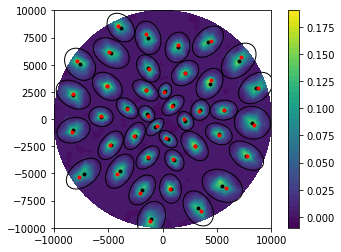

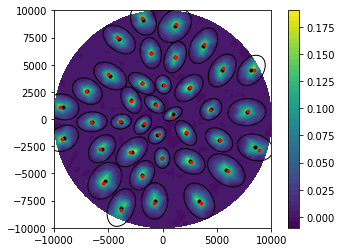

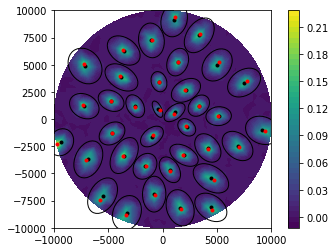

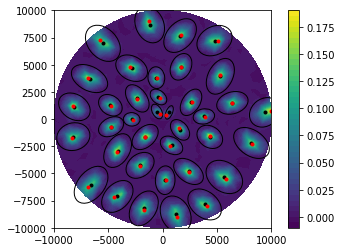

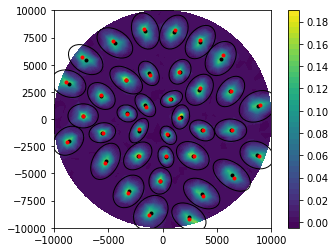

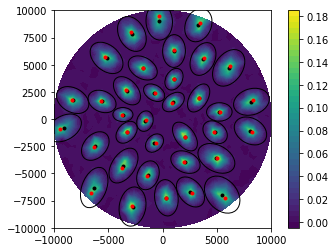

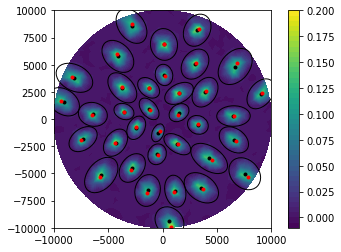

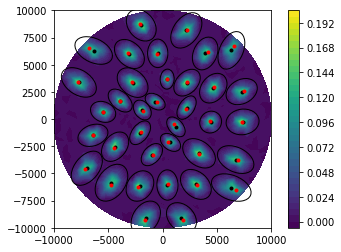

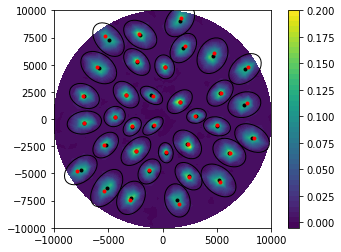

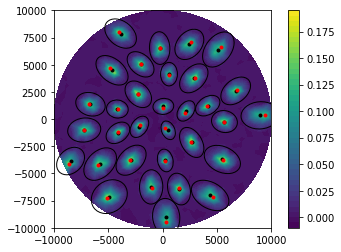

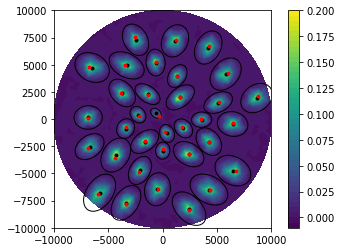

In [11]:
for b in range(len(lpsf_kernel.eta_batches)):
    eta_b = dl.Function(V)
    eta_b.vector()[:] = lpsf_kernel.eta_batches[b]

    plt.figure()
    cm = dl.plot(eta_b)
    plt.colorbar(cm)
    for ind in lpsf_kernel.dirac_ind_batches[b]:
        plt.plot(mu[ind][0], mu[ind][1], '.k')
        plot_ellipse(mu[ind], Sigma[ind], tau, edgecolor='k')
        plt.plot(vertices_dof_order[0,ind], vertices_dof_order[1,ind], '.r')

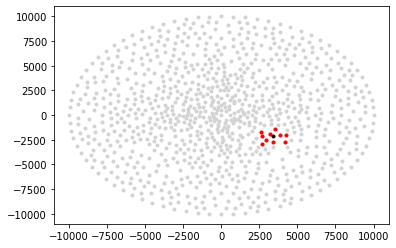

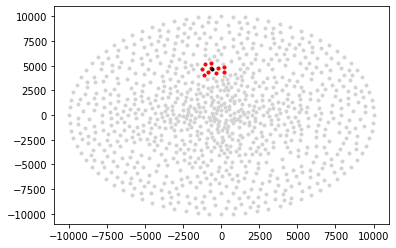

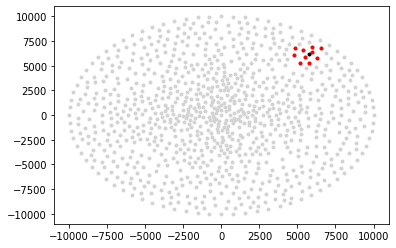

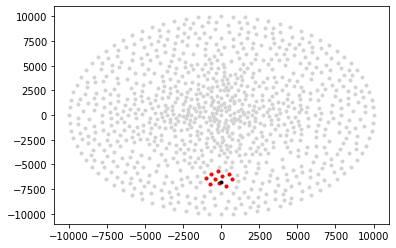

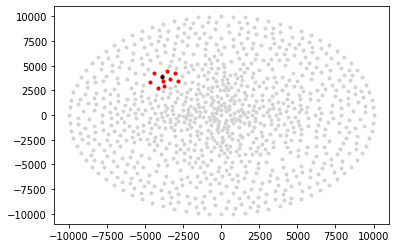

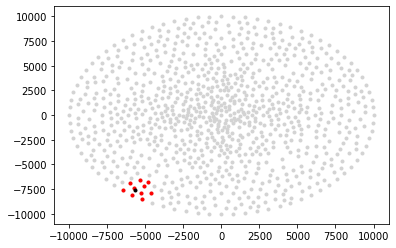

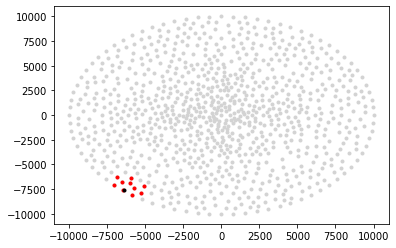

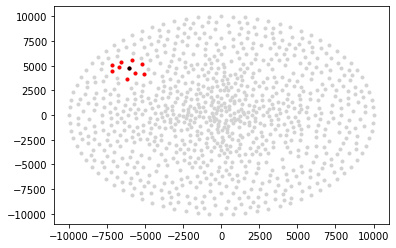

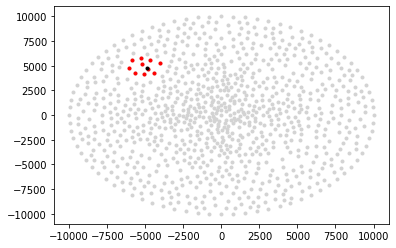

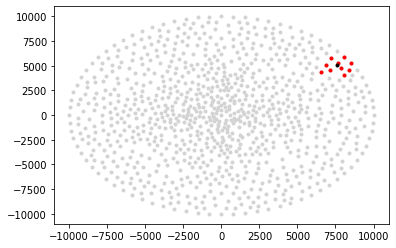

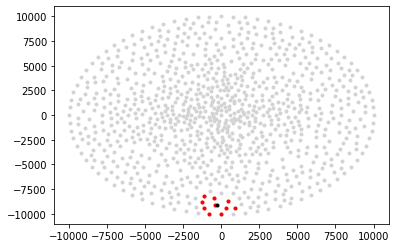

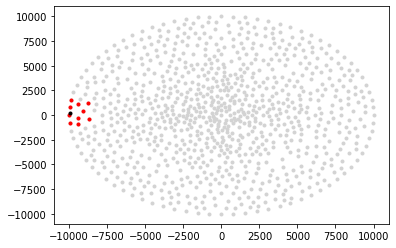

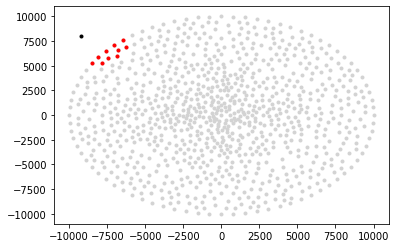

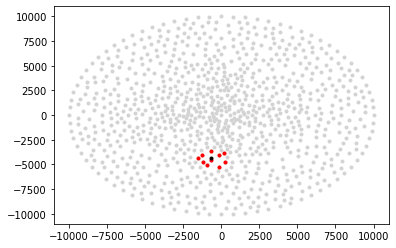

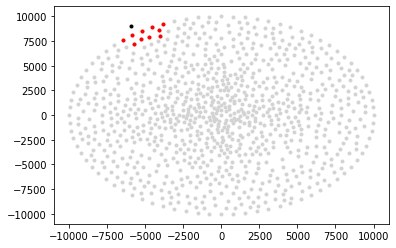

In [12]:
query_points = [np.array(1e4*(2*np.random.rand(2,1)-1), order='C') for _ in range(15)]

for q in query_points:
    nearest_inds = lpsf_kernel.dirac_kdtree.query(q, 10)[0].reshape(-1)

    plt.figure()
    for ind in lpsf_kernel.dirac_inds:
        plt.plot(lpsf_kernel.source_vertices[ind][0], lpsf_kernel.source_vertices[ind][1], '.', c='lightgray')

#     for ind in nearest_inds:
#         plt.plot(lpsf_kernel.source_vertices[ind][0], lpsf_kernel.source_vertices[ind][1], '.r')
    for ind in nearest_inds:
            plt.plot(lpsf_kernel.dirac_points[ind][0], lpsf_kernel.dirac_points[ind][1], '.r')

    plt.plot(q[0], q[1], '.k')

In [13]:
R_ker = ( 1.0 / mass_lumps.reshape((-1,1)) ) * (R / mass_lumps.reshape((1,-1)))

num_entries = 15
row_inds = list(np.random.randint(0, V.dim(), num_entries))
# col_inds = list(np.random.randint(0, V.dim(), num_entries))
col_inds = row_inds

for ii, jj in zip(row_inds, col_inds):
    v_true = Ker[ii,jj]
    v_CUR = lpsf_kernel.entry(ii,jj, 1, 1)
    v_LTI = lpsf_kernel.entry(ii,jj, 2, 1)
    v_LMDI = lpsf_kernel.entry(ii,jj, 3, 2)
    v_ELL = lpsf_kernel.entry(ii,jj, 0, 0)

    print('ii=', ii, ', jj=', jj)
    print('value_true=', np.format_float_scientific(v_true, precision=3), 
          ', v_CUR=', np.format_float_scientific(v_CUR, precision=3), 
          ', v_LTI=', np.format_float_scientific(v_LTI, precision=3), 
          ', v_LMDI=', np.format_float_scientific(v_LMDI, precision=3), 
          ', v_ELL=', np.format_float_scientific(v_ELL, precision=3), 
          )

ii= 740 , jj= 740
value_true= 9.508e-06 , v_CUR= 9.508e-06 , v_LTI= 9.508e-06 , v_LMDI= 9.508e-06 , v_ELL= 9.508e-06
ii= 1194 , jj= 1194
value_true= 1.036e-05 , v_CUR= 6.025e-06 , v_LTI= 1.42e-05 , v_LMDI= 1.036e-05 , v_ELL= 1.059e-05
ii= 737 , jj= 737
value_true= 7.757e-06 , v_CUR= 7.757e-06 , v_LTI= 7.757e-06 , v_LMDI= 7.757e-06 , v_ELL= 7.757e-06
ii= 391 , jj= 391
value_true= 1.359e-05 , v_CUR= 7.902e-06 , v_LTI= 1.628e-05 , v_LMDI= 1.375e-05 , v_ELL= 1.367e-05
ii= 1228 , jj= 1228
value_true= 8.299e-06 , v_CUR= 4.187e-06 , v_LTI= 8.411e-06 , v_LMDI= 6.003e-06 , v_ELL= 6.689e-06
ii= 43 , jj= 43
value_true= 1.735e-07 , v_CUR= 1.735e-07 , v_LTI= 1.735e-07 , v_LMDI= 1.735e-07 , v_ELL= 1.735e-07
ii= 857 , jj= 857
value_true= 1.272e-05 , v_CUR= 1.271e-05 , v_LTI= 1.271e-05 , v_LMDI= 1.271e-05 , v_ELL= 1.271e-05
ii= 634 , jj= 634
value_true= 4.551e-07 , v_CUR= 2.407e-07 , v_LTI= 4.944e-07 , v_LMDI= 3.826e-07 , v_ELL= 3.619e-07
ii= 1164 , jj= 1164
value_true= 3.225e-07 , v_CUR= 1.619e-07 , 

In [14]:
rows = list(np.arange(50))
cols = list(np.arange(50))

# B = lpsf_kernel.block(rows, cols, 1, 1)
# B = lpsf_kernel.block(rows, cols, 2, 1)
# B = lpsf_kernel.block(rows, cols, 2, 2)
# B = lpsf_kernel.block(rows, cols, 3, 1)
# B = lpsf_kernel.block(rows, cols, 3, 2)
# B = lpsf_kernel.block(rows, cols, 3, 0)
B = lpsf_kernel.block(rows, cols, 0, 0)
B_true = Ker[np.ix_(rows, cols)]

err_B = np.linalg.norm(B_true - B) / np.linalg.norm(B_true)
print('err_B=', err_B)

err_B= 0.03615743191326199


<Figure size 432x288 with 0 Axes>

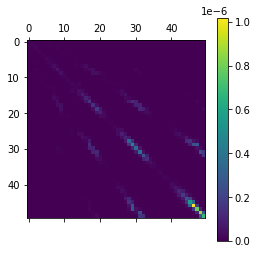

<Figure size 432x288 with 0 Axes>

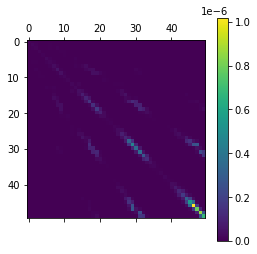

In [15]:
plt.figure()
plt.matshow(np.abs(B))
plt.colorbar()

plt.figure()
plt.matshow(np.abs(B_true))
plt.colorbar()

/tmp/ipykernel_603776/3776181403.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

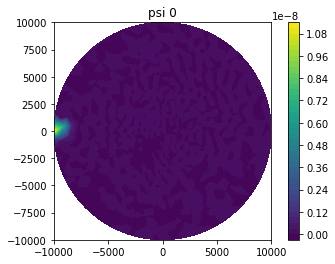

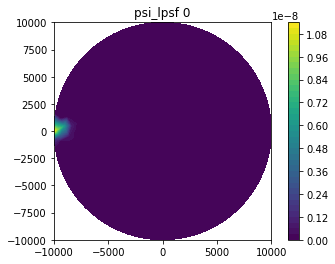

<Figure size 432x288 with 0 Axes>

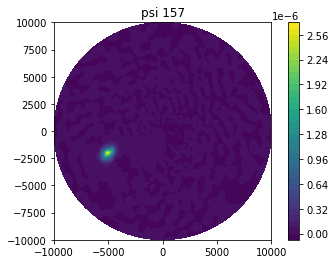

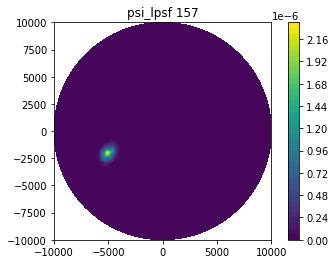

<Figure size 432x288 with 0 Axes>

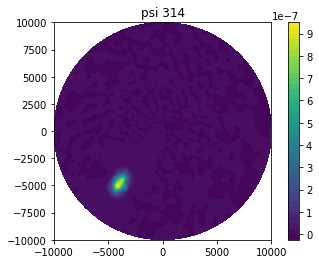

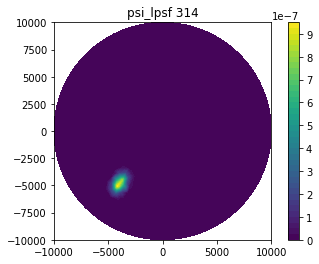

<Figure size 432x288 with 0 Axes>

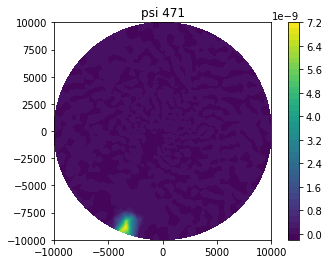

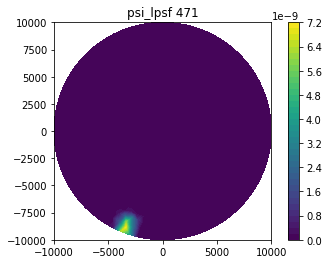

<Figure size 432x288 with 0 Axes>

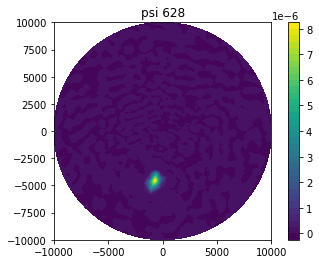

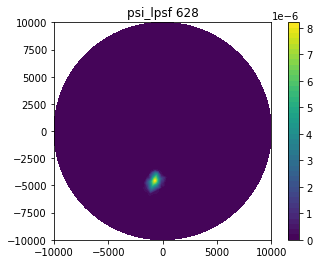

<Figure size 432x288 with 0 Axes>

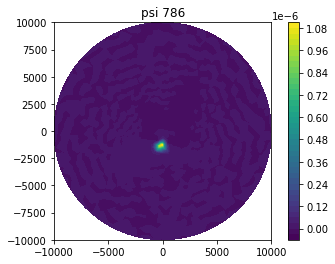

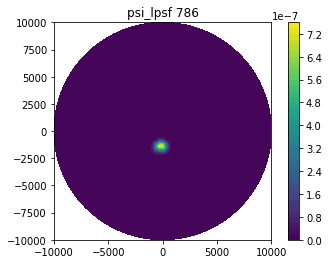

<Figure size 432x288 with 0 Axes>

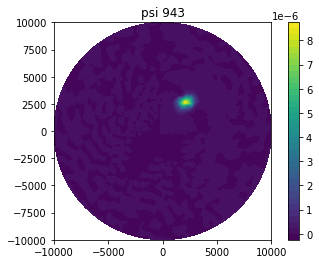

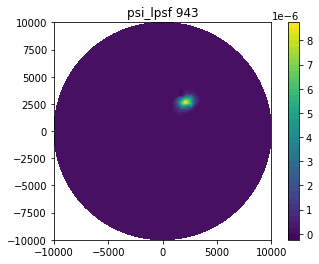

<Figure size 432x288 with 0 Axes>

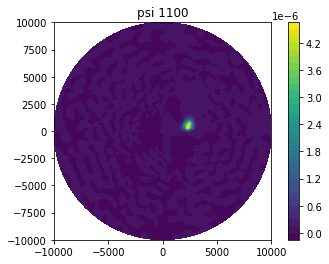

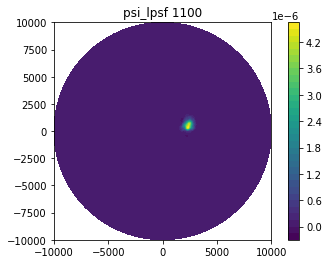

<Figure size 432x288 with 0 Axes>

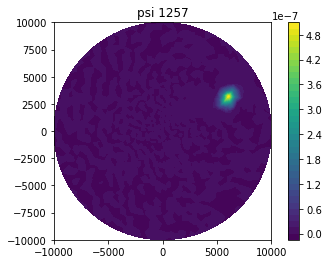

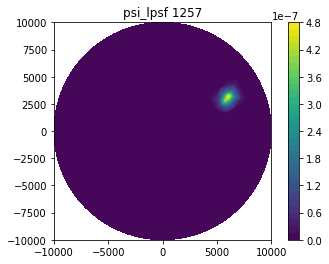

<Figure size 432x288 with 0 Axes>

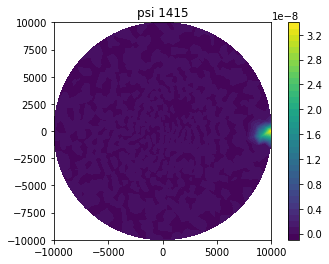

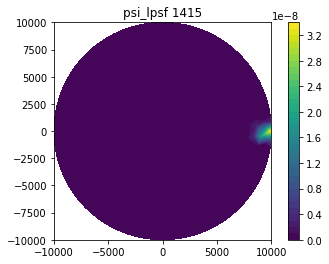

In [16]:
lpsf_kernel.num_neighbors = 10

kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    plt.figure()
    psi_k = dl.Function(V)
    psi_k.vector()[:] = Ker[:,k].copy()

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)
    plt.title('psi '+str(k))

    psi_k_lpsf = dl.Function(V)
#     psi_k_lpsf.vector()[:] = lpsf_kernel.block(list(np.arange(V.dim())), [k], 1, 1).reshape(-1).copy()
#     psi_k_lpsf.vector()[:] = lpsf_kernel.block(list(np.arange(V.dim())), [k], 2, 1).reshape(-1).copy()
#     psi_k_lpsf.vector()[:] = lpsf_kernel.block(list(np.arange(V.dim())), [k], 3, 2).reshape(-1).copy()
    psi_k_lpsf.vector()[:] = lpsf_kernel.block(list(np.arange(V.dim())), [k], 0, 0).reshape(-1).copy()
    plt.figure()
    cm = dl.plot(psi_k_lpsf)
    plt.colorbar(cm)
    plt.title('psi_lpsf '+str(k))

In [17]:
lpsf_kernel.num_neighbors = 10

rows = list(np.arange(V.dim()))
cols = list(np.arange(V.dim()))

t = time()
# Ker_lpsf = lpsf_kernel.block(rows, cols, 1, 1) # CUR
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 1) # LTI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 2) # LTI + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 2) # LMDI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 0) # LMDI + det
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 2) # ELL + vol
Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 0) # ELL
dt_toarray = time() - t
print('dt_toarray=', dt_toarray)

err_Ker = np.linalg.norm(Ker - Ker_lpsf) / np.linalg.norm(Ker)
print('err_Ker=', err_Ker)

Hdgn_lpsf = mass_lumps.reshape((1,-1)) * Ker_lpsf * mass_lumps.reshape((-1,1))

err_Hdgn = np.linalg.norm(Hdgn - Hdgn_lpsf) / np.linalg.norm(Hdgn)
print('err_Hdgn=', err_Hdgn)

dt_toarray= 35.350908279418945
err_Ker= 0.12014512161881237
err_Hdgn= 0.09355050366872802


Text(0.5, 1.0, 'col_errs_ker')

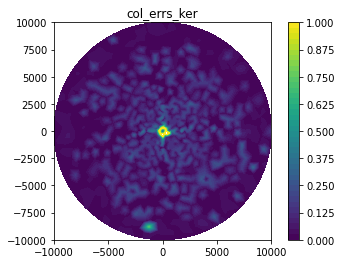

In [18]:
col_errs_ker_vec = np.linalg.norm(Ker_lpsf - Ker, axis=0) / np.linalg.norm(Ker, axis=0)
# col_errs_ker_vec = np.linalg.norm(Ker_lpsf - Ker, axis=0)

col_errs_ker = dl.Function(V)
# col_errs_ker.vector()[:] = np.log10(col_errs_ker_vec)
col_errs_ker.vector()[:] = np.min([col_errs_ker_vec, 5.0 * np.ones(V.dim())], axis=0)
cm = dl.plot(col_errs_ker)
plt.colorbar(cm)
plt.title('col_errs_ker')

Text(0.5, 1.0, 'col_errs')

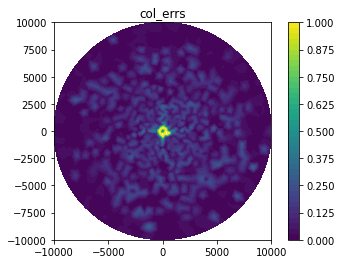

In [19]:
col_errs_vec = np.linalg.norm(Hdgn_lpsf - Hdgn, axis=0) / np.linalg.norm(Hdgn, axis=0)

col_errs = dl.Function(V)
# col_errs.vector()[:] = np.log10(col_errs_vec)
col_errs.vector()[:] = np.min([col_errs_vec, 5.0 * np.ones(V.dim())], axis=0)
cm = dl.plot(col_errs)
plt.colorbar(cm)
plt.title('col_errs')

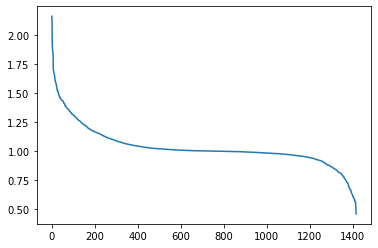

In [20]:
Hdgn_lpsf_sym = 0.5*(Hdgn_lpsf + Hdgn_lpsf.T)
Hdgn_lpsf_plus = sla.sqrtm(Hdgn_lpsf_sym.T @ Hdgn_lpsf_sym)

ee_ELL, U = sla.eigh(Hdgn + R, Hdgn_lpsf_plus + R)

plt.plot(ee_ELL[::-1])

In [21]:
lpsf_kernel.num_neighbors = 10

rows = list(np.arange(V.dim()))
cols = list(np.arange(V.dim()))

t = time()
# Ker_lpsf = lpsf_kernel.block(rows, cols, 1, 1) # CUR
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 1) # LTI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 2) # LTI + vol
Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 2) # LMDI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 0) # LMDI + det
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 2) # ELL + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 0) # ELL
dt_toarray = time() - t
print('dt_toarray=', dt_toarray)

err_Ker = np.linalg.norm(Ker - Ker_lpsf) / np.linalg.norm(Ker)
print('err_Ker=', err_Ker)

Hdgn_lpsf = mass_lumps.reshape((1,-1)) * Ker_lpsf * mass_lumps.reshape((-1,1))

err_Hdgn = np.linalg.norm(Hdgn - Hdgn_lpsf) / np.linalg.norm(Hdgn)
print('err_Hdgn=', err_Hdgn)

dt_toarray= 33.3189914226532
err_Ker= 0.13162809848854273
err_Hdgn= 0.1050784497690489


In [22]:
Hdgn_lpsf_sym = 0.5*(Hdgn_lpsf + Hdgn_lpsf.T)
Hdgn_lpsf_plus = sla.sqrtm(Hdgn_lpsf_sym.T @ Hdgn_lpsf_sym)

ee_LDMI, U = sla.eigh(Hdgn + R, Hdgn_lpsf_plus + R)

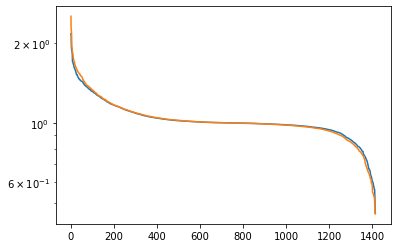

In [23]:
plt.semilogy(ee_ELL[::-1])
plt.semilogy(ee_LDMI[::-1])

In [24]:
lpsf_kernel.num_neighbors = 10

rows = list(np.arange(V.dim()))
cols = list(np.arange(V.dim()))

t = time()
# Ker_lpsf = lpsf_kernel.block(rows, cols, 1, 1) # CUR
Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 1) # LTI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 2) # LTI + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 2) # LMDI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 0) # LMDI + det
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 2) # ELL + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 0) # ELL
dt_toarray = time() - t
print('dt_toarray=', dt_toarray)

err_Ker = np.linalg.norm(Ker - Ker_lpsf) / np.linalg.norm(Ker)
print('err_Ker=', err_Ker)

Hdgn_lpsf = mass_lumps.reshape((1,-1)) * Ker_lpsf * mass_lumps.reshape((-1,1))

err_Hdgn = np.linalg.norm(Hdgn - Hdgn_lpsf) / np.linalg.norm(Hdgn)
print('err_Hdgn=', err_Hdgn)

dt_toarray= 33.33634567260742
err_Ker= 0.2160841019802031
err_Hdgn= 0.16095181337896358


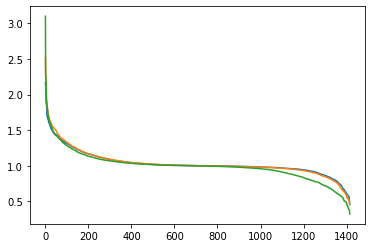

In [25]:
Hdgn_lpsf_sym = 0.5*(Hdgn_lpsf + Hdgn_lpsf.T)
Hdgn_lpsf_plus = sla.sqrtm(Hdgn_lpsf_sym.T @ Hdgn_lpsf_sym)

ee_LTI, U = sla.eigh(Hdgn + R, Hdgn_lpsf_plus + R)

plt.plot(ee_ELL[::-1])
plt.plot(ee_LDMI[::-1])
plt.plot(ee_LTI[::-1])

In [26]:
lpsf_kernel.num_neighbors = 10

rows = list(np.arange(V.dim()))
cols = list(np.arange(V.dim()))

t = time()
Ker_lpsf = lpsf_kernel.block(rows, cols, 1, 1) # CUR
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 1) # LTI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 2, 2) # LTI + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 2) # LMDI
# Ker_lpsf = lpsf_kernel.block(rows, cols, 3, 0) # LMDI + det
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 2) # ELL + vol
# Ker_lpsf = lpsf_kernel.block(rows, cols, 0, 0) # ELL
dt_toarray = time() - t
print('dt_toarray=', dt_toarray)

err_Ker = np.linalg.norm(Ker - Ker_lpsf) / np.linalg.norm(Ker)
print('err_Ker=', err_Ker)

Hdgn_lpsf = mass_lumps.reshape((1,-1)) * Ker_lpsf * mass_lumps.reshape((-1,1))

err_Hdgn = np.linalg.norm(Hdgn - Hdgn_lpsf) / np.linalg.norm(Hdgn)
print('err_Hdgn=', err_Hdgn)

dt_toarray= 36.61483716964722
err_Ker= 0.32727937025182735
err_Hdgn= 0.2622521659035823


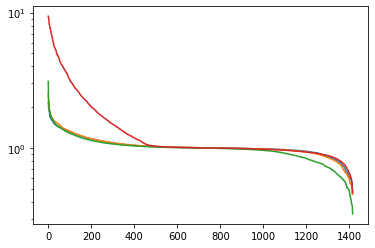

In [27]:
Hdgn_lpsf_sym = 0.5*(Hdgn_lpsf + Hdgn_lpsf.T)
Hdgn_lpsf_plus = sla.sqrtm(Hdgn_lpsf_sym.T @ Hdgn_lpsf_sym)

ee_CUR, U = sla.eigh(Hdgn + R, Hdgn_lpsf_plus + R)

plt.semilogy(ee_ELL[::-1])
plt.semilogy(ee_LDMI[::-1])
plt.semilogy(ee_LTI[::-1])
plt.semilogy(ee_CUR[::-1])

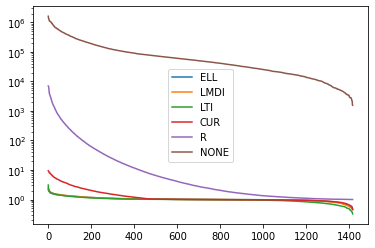

In [28]:
ee_R, U = sla.eigh(Hdgn + R, R)
ee_NONE, U = sla.eigh(Hdgn + R)

plt.semilogy(ee_ELL[::-1])
plt.semilogy(ee_LDMI[::-1])
plt.semilogy(ee_LTI[::-1])
plt.semilogy(ee_CUR[::-1])
plt.semilogy(ee_R[::-1])
plt.semilogy(ee_NONE[::-1])
plt.legend(['ELL', 'LMDI', 'LTI', 'CUR', 'R', 'NONE'])

In [29]:
ee_ELL[-1] / ee_ELL[0]

4.7259579808751475